    ==============================================================================================

## Importing the DataFrames
- ``` df = pd.read_pickle("file_name.pkl")```  --> create 1 df from a pkl file

In [123]:
import pandas as pd
import numpy as np
pd.set_option("display.min_rows", 0) 
pd.set_option("display.max_rows", 30) 
pd.__version__

'1.4.4'

In [124]:
db_qu = pd.read_pickle("clean_Tables\Merged_c.pkl")

In [125]:

db_qu_rows = db_qu.shape[0]
db_qu_rows

60943

In [126]:
db_qu.columns

Index(['ORD_ID', 'ord_CreatDate', 'ord_TotlPaid', 'OL_ID', 'ol_ProdQnty',
       'ol_ProdUntPr', 'ol_ProcessDate', 'PRO_SKU', 'pro_Name', 'pro_Desc',
       'pro_Pr', 'pro_InStock', 'pro_Type'],
      dtype='object')

In [127]:
#ord_qu = db_qu[['ORD_ID', 'ord_CreatDate', 'ord_TotlPaid']].copy()

In [128]:
#ol_qu = db_qu[['OL_ID', 'ol_ProdQnty', 'ol_ProdUntPr', 'ol_ProcessDate']].copy()

In [129]:
#pro_qu = db_qu[['PRO_SKU', 'pro_Name', 'pro_Desc', 'pro_Pr', 'pro_InStock', 'pro_Type']].copy()

    ==============================================================================================

## Answer Bussines questions


Concerns
A. The main investors pointed out the company’s recent quarterly results showed
    1.  increase in orders placed but a decrease in the total revenue. 
 They prefer that the company positions itself in the quality segment, rather than competing to offer the lowest prices in the market.
B. Questions
    1. How products should be classified into different categories to simplify reports and analysis.
    2. What is the distribution of product prices across different categories.
    3. How many products are being discounted.
    4. How big are the offered discounts as a percentage of the product prices. --> tmp_dis_per

### A.1. Revenue per Order
- Recap:
    - ord_TotlPaid : total amount paid by the customer for this order (euros)
    - ol_ProdUntPr : the unitary price (euros) of each product at the moment of placing that order
    - ol_ProdQnty  : how many units of that product were purchased on that order
- per row(OL) : ol_ProdUntPr * ol_ProdQnty = tmp_ol_price
- group by ORD_ID .sum of the tmp_ol_price = tmp_ord_price
- compare the tmp_ord_price with ord_TotlPaid

In [ ]:
drop_lst = ["ol_ProcessDate","PRO_SKU","pro_Name","pro_Desc","pro_InStock","pro_Type"]

In [ ]:
db_qu["tmp_ol_price"] = db_qu.ol_ProdUntPr * db_qu.ol_ProdQnty

In [ ]:
db_qu.tmp_ol_price.means="db_qu.ol_ProdUntPr * db_qu.ol_ProdQnty"

In [ ]:

db_ordRev=(
    db_qu
    .groupby("ORD_ID")
    .agg(tmp_ord_Rev=('tmp_ol_price', 'sum'))
    .merge(db_qu,on="ORD_ID")
).drop_duplicates(subset="ORD_ID")

In [ ]:
#db_ordRev.tmp_ord_Rev.means="groupby ORD_ID, agg tmp_ol_price --> sum"

In [ ]:
#db_ordRev.tmp_ord_Rev.means

In [ ]:

db_ordRev=(
    db_ordRev
    .assign(tmp_ord_Pr_diff = db_ordRev.ord_TotlPaid-db_ordRev.tmp_ord_Rev)
    .drop(columns=drop_lst)
    .drop(columns = ["tmp_ol_price","OL_ID","ol_ProdQnty",	"ol_ProdUntPr",	"pro_Pr"])
    .reindex(columns=['ORD_ID', 'ord_CreatDate', 'ord_TotlPaid', 'tmp_ord_Rev', 'tmp_ord_Pr_diff'])
)

In [ ]:
# db_ordRev.tmp_ord_Pr_diff.means='''db_ordRev.ord_TotlPaid - db_ordRev.tmp_ord_Rev 
# In ideal cases, this value should 0
# +ve means customer paid extra costs (ie delivery)
# -ve means customer paid less than he should!! '''

In [ ]:
db_ordRev.sample(5)

,ORD_ID,ord_CreatDate,ord_TotlPaid,tmp_ord_Rev,tmp_ord_Pr_diff
11254,348210,2017-04-21 10:53:28,53.99,53.99,0.00
10702,346780,2017-04-18 12:29:57,322.99,322.99,0.00
46934,474398,2017-12-28 08:01:11,23.98,16.99,6.99
13600,356543,2017-05-17 10:29:35,569.97,569.97,0.00
55961,507581,2018-02-07 17:42:11,56.55,52.56,3.99


In [ ]:
db_ordRev.tmp_ord_Pr_diff.describe()

count    45905.000000
mean         7.351494
std         62.456507
min       -165.000000
25%          0.000000
50%          4.990000
75%          6.990000
max       3984.990000
Name: tmp_ord_Pr_diff, dtype: float64

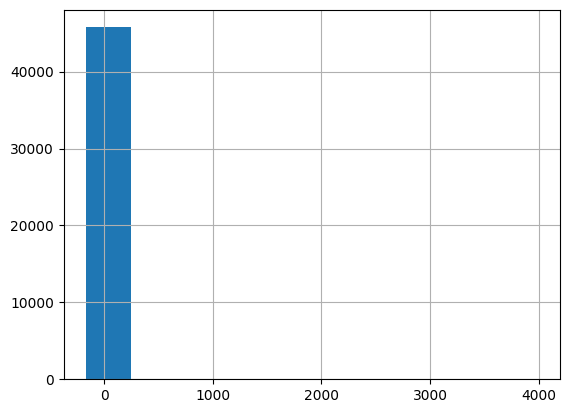

In [ ]:
db_ordRev.tmp_ord_Pr_diff.hist();

Calculate Outlier

In [ ]:
Q1 = db_ordRev.tmp_ord_Pr_diff.quantile(0.25)
Q3 = db_ordRev.tmp_ord_Pr_diff.quantile(0.75)
IQR=Q3-Q1

In [ ]:
num_inliers =((db_ordRev.tmp_ord_Pr_diff >= (Q1 - 1.5*IQR)) & (db_ordRev.tmp_ord_Pr_diff <= (Q3 + 1.5*IQR))).sum()
num_outliers = db_ordRev.shape[0]-num_inliers 
per_outliers = round((num_outliers/db_ordRev.shape[0])*100,2)
print(f'''{num_outliers} out of {db_ordRev.shape[0]} are outliers from tmp_ord_Pr_diff ,ie {per_outliers}%''') 

1105 out of 45905 are outliers from tmp_ord_Pr_diff ,ie 2.41%


In [ ]:
db_ordRev=db_ordRev.loc[(db_ordRev.tmp_ord_Pr_diff >= (Q1 - 1.5*IQR)) & (db_ordRev.tmp_ord_Pr_diff <= (Q3 + 1.5*IQR))]

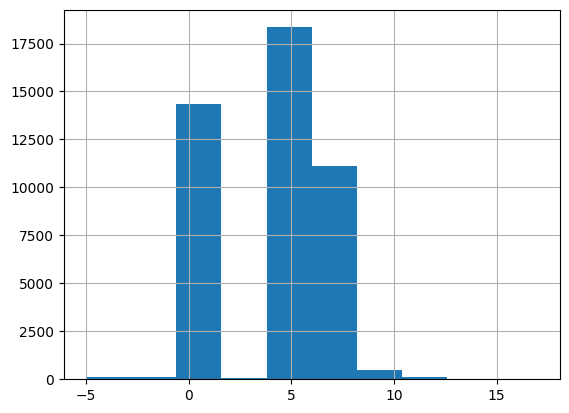

In [ ]:
db_ordRev.tmp_ord_Pr_diff.hist();

In [ ]:
round(db_ordRev.tmp_ord_Pr_diff.describe(),2)

count    44800.00
mean         3.77
std          2.92
min         -5.00
25%          0.00
50%          4.99
75%          6.99
max         16.97
Name: tmp_ord_Pr_diff, dtype: float64

Check Revenue/num of Orders OverTime

In [ ]:
db_ordRev.sample()

,ORD_ID,ord_CreatDate,ord_TotlPaid,tmp_ord_Rev,tmp_ord_Pr_diff
39700,446880,2017-11-27 04:27:14,29.93,22.94,6.99


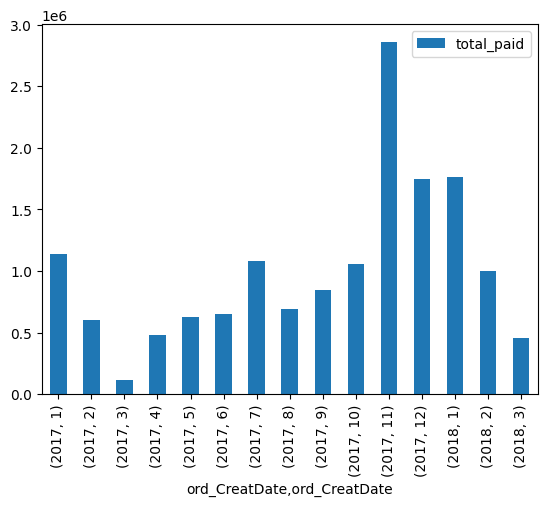

In [ ]:
(
    db_ordRev
    .groupby([db_ordRev.ord_CreatDate.dt.year,db_ordRev.ord_CreatDate.dt.month])
    .agg(total_paid =("ord_TotlPaid","sum"))
    .plot(kind="bar")
);
#Note: shall compare first 3 months of each yaer with eachother

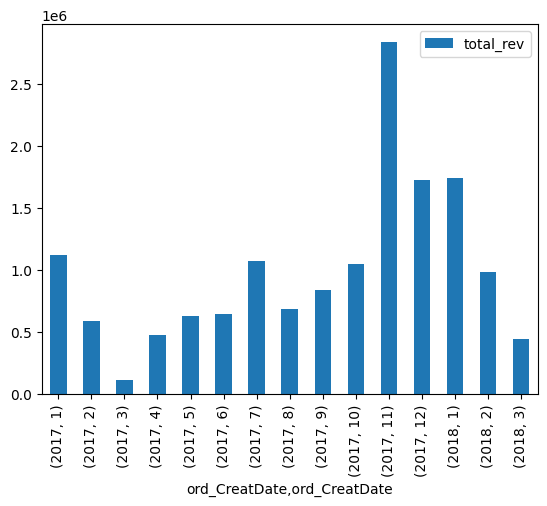

In [ ]:
(
    db_ordRev
    .groupby([db_ordRev.ord_CreatDate.dt.year,db_ordRev.ord_CreatDate.dt.month])
    .agg(total_rev =("tmp_ord_Rev","sum"))
    .plot(kind="bar")
);

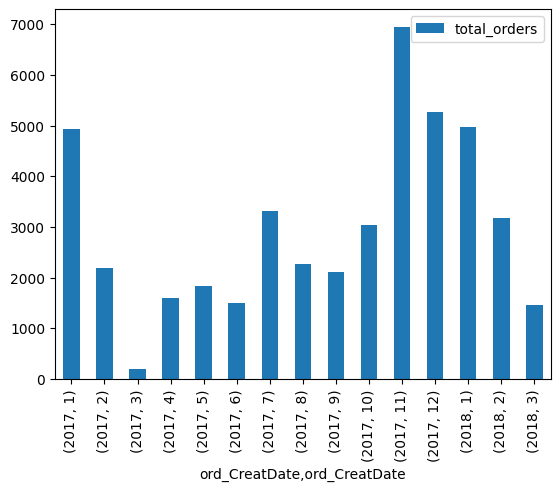

In [ ]:
(
    db_ordRev
    .groupby([db_ordRev.ord_CreatDate.dt.year,db_ordRev.ord_CreatDate.dt.month])
    .agg(total_orders =("ORD_ID","count"))
    .plot(kind="bar")
);

- Conclusion

In [ ]:
print(f''' Looking to the diagram, The Revenue has been decreased for Q1 2018 WRT to q4 2017
      BUT Its normally not recommanded to compare 2 different quarters/months within year with each others.
      Best Practice recomand to compare same Quarter of different years to consider seasonal events
      Hence looking to Q1 2017, The Revenue as well as number of Orders has been already Increased!!
      Means the Main Investor concerns are not quite real''')

### B.3/4 Discounts per product (db_proDis)
- Recap:
    - ol_ProdUntPr : the unitary price (euros) of each product at the moment of placing that order
    - pro_Pr       : product price without discounts
- check if rows are unique for sku
- discounts per product --> pro_Pr - ol_ProdUntPr

In [150]:
drop_lst_proDis =["ORD_ID","ord_CreatDate","ol_ProcessDate","ord_TotlPaid","OL_ID","ol_ProdQnty","pro_Desc","pro_InStock","tmp_ol_price"]


In [151]:
db_proDis=(
    db_qu
    #.drop(columns=drop_lst_proDis)
    #.reindex(columns=["PRO_SKU","pro_Name","pro_Type","ol_ProdUntPr","pro_Pr"])
    .assign(tmp_pro_dis = db_qu.pro_Pr - db_qu.ol_ProdUntPr)
)

In [152]:
# db_proDis.tmp_pro_dis.means = '''db_qu.pro_Pr - db_qu.ol_ProdUntPr, 
# -ve means item sold higher than original price
# 0 means no discount'''

In [153]:
(db_proDis.tmp_pro_dis == 0).sum()

2492

In [154]:
db_proDis.sample()

,ORD_ID,ord_CreatDate,ord_TotlPaid,OL_ID,ol_ProdQnty,ol_ProdUntPr,ol_ProcessDate,PRO_SKU,pro_Name,pro_Desc,pro_Pr,pro_InStock,pro_Type,tmp_ol_price,tmp_pro_dis
55683,495428,2018-01-28 14:55:49,171.97,1584619,1,16.99,2018-01-28 14:47:32,OTT0111,OtterBox iPhone Case 2.0 Symmetry 6 / 6s Beige,Protective Cover for iPhone 6 and 6s,34.99,True,11865403,16.99,18.0


#### 3. How many products are being discounted.
    - means for tmp_pro_dis > 0
        - count unique PRO_SKU
        - count product ol_ProdQnty

In [155]:
# db_proDis.tmp_pro_dis.means

In [156]:

x=(
    db_proDis
    .query("tmp_pro_dis> 0")
    .agg(Prod_num=("PRO_SKU",pd.Series.nunique),Prod_Qnty_sum=("ol_ProdQnty","sum"))
)
x

,PRO_SKU,ol_ProdQnty
Prod_num,5681.0,NaN
Prod_Qnty_sum,NaN,63571.0


- Conclusion

In [157]:
print(f" Considering Unique SKU : {round(x.PRO_SKU[0]/db_proDis.PRO_SKU.nunique()*100,2)}% of all sold product are discounted")
print(f" Considering Sum of Quantities : {round(x.ol_ProdQnty[1]/db_proDis.ol_ProdQnty.sum()*100,2)}% of all sold products Quantities are discounted")

 Considering Unique SKU : 96.53% of all sold product are discounted
 Considering Sum of Quantities : 93.01% of all sold products Quantities are discounted


In [158]:
print(f"That means specific types of products are mor in discount")

That means specific types of products are mor in discount


#### 4. How big are the offered discounts as a percentage of the product prices.

In [159]:
db_proDis= (
    db_proDis
    .assign(tmp_dis_per = np.where((db_proDis.pro_Pr== 0.0)
                                   ,100
                                   ,round((db_proDis.tmp_pro_dis/db_proDis.pro_Pr)*100,2)
                                   ))
    )

In [160]:
# db_proDis.tmp_dis_per.means=''' amount of discount per product, 
# -ve means item sold higher than original price
# 0 means no discount
# 100 means item was sold for free '''

In [161]:
db_proDis.tmp_dis_per.describe()

count    60943.000000
mean        21.267464
std         18.752120
min       -212.270000
25%          8.330000
50%         17.270000
75%         28.290000
max        100.000000
Name: tmp_dis_per, dtype: float64

In [162]:
db_proDis.loc[db_proDis.tmp_dis_per < -212 ]

,ORD_ID,ord_CreatDate,ord_TotlPaid,OL_ID,ol_ProdQnty,ol_ProdUntPr,ol_ProcessDate,PRO_SKU,pro_Name,pro_Desc,pro_Pr,pro_InStock,pro_Type,tmp_ol_price,tmp_pro_dis,tmp_dis_per
43318,347233,2017-04-25 10:53:24,64.91,1233154,1,24.95,2017-04-22 12:20:43,IFX0074,iFixit piece Earpiece Speaker iPhone 6,Handset internal speaker for iPhone 6,7.99,True,21485407,24.95,-16.96,-212.27
43319,379925,2017-07-20 12:33:12,31.94,1297936,1,24.95,2017-07-20 12:27:58,IFX0074,iFixit piece Earpiece Speaker iPhone 6,Handset internal speaker for iPhone 6,7.99,True,21485407,24.95,-16.96,-212.27
43320,388586,2017-08-11 10:27:30,66.93,1316185,1,24.95,2017-08-11 09:29:25,IFX0074,iFixit piece Earpiece Speaker iPhone 6,Handset internal speaker for iPhone 6,7.99,True,21485407,24.95,-16.96,-212.27


<AxesSubplot:>

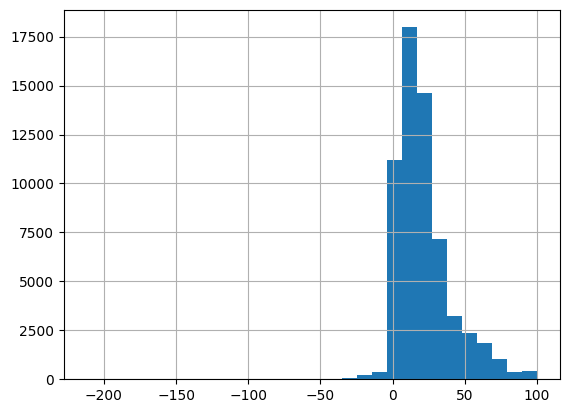

In [163]:
db_proDis.tmp_dis_per.hist(bins=30)

- Remove Outliers

In [164]:
Q1 = db_proDis.tmp_dis_per.quantile(0.25)
Q3 = db_proDis.tmp_dis_per.quantile(0.75)
IQR=Q3-Q1


In [165]:

inliers = (db_proDis.tmp_dis_per >= (Q1 - 1.5*IQR)) & (db_proDis.tmp_dis_per <= (Q3 + 1.5*IQR))
num_inliers = inliers.sum()
num_outliers = db_proDis.shape[0]-num_inliers 
per_outliers = round((num_outliers/db_proDis.shape[0])*100,2)
print(f'''{num_outliers} out of {db_proDis.shape[0]} are outliers from tmp_dis_per ,ie {per_outliers}%''') 

3857 out of 60943 are outliers from tmp_dis_per ,ie 6.33%


In [166]:
db_proDis = db_proDis.loc[inliers]

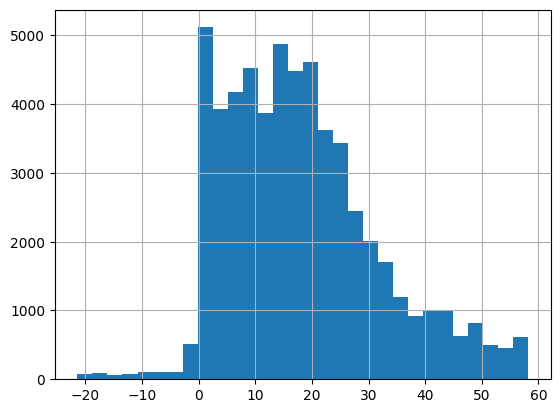

In [167]:
db_proDis.tmp_dis_per.hist(bins=30);

In [170]:
db_proDis.tmp_dis_per.describe()

count    57086.000000
mean        18.101614
std         13.647078
min        -21.410000
25%          7.720000
50%         16.420000
75%         25.590000
max         58.210000
Name: tmp_dis_per, dtype: float64

- Conclusion

In [172]:
print(f"The discounts grows up to {db_proDis.tmp_dis_per.max()}% of the product original price")

The discounts grows up to 58.21% of the product original price


Discounts over time

<AxesSubplot:xlabel='ord_CreatDate,ord_CreatDate'>

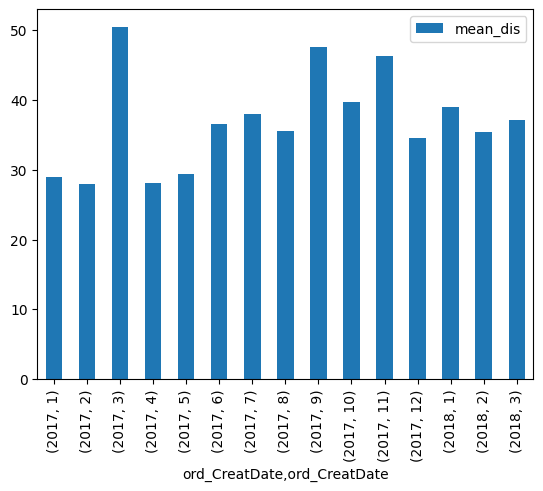

In [174]:
(
    db_proDis
    .groupby([db_proDis.ord_CreatDate.dt.year,db_proDis.ord_CreatDate.dt.month])
    .agg(mean_dis =("tmp_pro_dis","mean"))
    .plot(kind="bar")
    #.sort_values(by="mean_dis"
                 #,ascending=False
                # )
)

In [251]:
db_proDis.sample(5)

,ORD_ID,ord_CreatDate,ord_TotlPaid,OL_ID,ol_ProdQnty,ol_ProdUntPr,ol_ProcessDate,PRO_SKU,pro_Name,pro_Desc,pro_Pr,pro_InStock,pro_Type,tmp_ol_price,tmp_pro_dis,tmp_dis_per,tmp_pr_cat
50089,372826,2017-07-08 08:57:00,64.98,1282813,1,59.99,2017-07-05 11:34:19,TWS0118,Twelve South BookBook Case Black iPhone 7 Plus,Cover with vintage design book store card slot front cover and support for iPhone 7 Plus,59.99,False,11865403,59.99,0.00,0.0,B
28037,375297,2017-07-10 12:13:10,404.95,1288154,1,18.99,2017-07-10 12:08:17,FCM0011,FCM Mac Memory 2GB 800MHz DDR2 SO-DIMM,2GB RAM iMac Early 2008.,19.99,False,1364,18.99,1.00,5.0,A
15554,303198,2017-01-09 23:29:00,148.98,1138317,1,94.99,2017-01-09 23:25:39,BEL0270,PowerHouse Base Load Belkin Apple Watch and iPhone White,Lightning charger and connection support and magnetic base for Apple Watch and iPhone (MFi),99.99,True,13615399,94.99,5.00,5.0,B
44327,404450,2017-09-25 16:37:31,367.32,1361423,1,360.33,2017-09-25 16:27:54,APP1968,Apple iPhone 32GB Gold,New iPhone SE with 4-inch screen 32 free GB.,419.00,False,51601716,360.33,58.67,14.0,C
20946,348149,2017-04-21 09:38:33,84.99,1232109,1,84.99,2017-04-21 09:35:12,FCM0003-2,Mac memory FCM 8GB (2x4GB) SO-DIMM DDR3 1066MHz,RAM 8GB (2x4GB) Mac mini iMac MacBook and MacBook Pro (2009/10).,87.98,False,1364,84.99,2.99,3.4,B


### B.1/2 product Categorization (db_proDis)
- Recap:
    - ol_ProdUntPr : the unitary price (euros) of each product at the moment of placing that order
    - pro_Pr       : product price without discounts
- check if rows are unique for sku
- discounts per product --> pro_Pr - ol_ProdUntPr

In [ ]:
drop_list=["ORD_ID","tmp_pr_cat","ord_TotlPaid","ol_ProdQnty","ord_CreatDate","OL_ID","ol_ProcessDate","pro_InStock","tmp_ol_price","tmp_pro_dis"]

In [242]:
db_proCat = db_proDis.drop(columns=drop_list)

__ Category via pro_Type

In [243]:
db_proCat.pro_Type.nunique()

121

In [ ]:
db_proCat.loc[db_proDis.pro_Type.str.len() == 9]

In [272]:
db_proCat=(
    db_proCat
    .assign(tmp_type_1=db_proCat.pro_Type.str.extract("^(\d{4,5})(\d{4})?$")[0])
    .assign(tmp_type_2=db_proCat.pro_Type.str.extract("^(\d{4,5})(\d{4})?$")[1])
)

In [291]:
(
    db_proCat
    .query("tmp_type_2 == '5397'")
)

,ol_ProdUntPr,PRO_SKU,pro_Name,pro_Desc,pro_Pr,pro_Type,tmp_dis_per,tmp_type_1,tmp_type_2
0,129.16,LAC0212,LaCie Porsche Design Desktop Drive 4TB USB 3.0 External Hard Drive,External Hard Drive 4TB 35-inch USB 3.0 for Mac and PC.,139.99,11935397,7.74,1193,5397
1,136.99,LAC0212,LaCie Porsche Design Desktop Drive 4TB USB 3.0 External Hard Drive,External Hard Drive 4TB 35-inch USB 3.0 for Mac and PC.,139.99,11935397,2.14,1193,5397
2,136.99,LAC0212,LaCie Porsche Design Desktop Drive 4TB USB 3.0 External Hard Drive,External Hard Drive 4TB 35-inch USB 3.0 for Mac and PC.,139.99,11935397,2.14,1193,5397
3,136.99,LAC0212,LaCie Porsche Design Desktop Drive 4TB USB 3.0 External Hard Drive,External Hard Drive 4TB 35-inch USB 3.0 for Mac and PC.,139.99,11935397,2.14,1193,5397
4,136.99,LAC0212,LaCie Porsche Design Desktop Drive 4TB USB 3.0 External Hard Drive,External Hard Drive 4TB 35-inch USB 3.0 for Mac and PC.,139.99,11935397,2.14,1193,5397
5,136.99,LAC0212,LaCie Porsche Design Desktop Drive 4TB USB 3.0 External Hard Drive,External Hard Drive 4TB 35-inch USB 3.0 for Mac and PC.,139.99,11935397,2.14,1193,5397
6,136.99,LAC0212,LaCie Porsche Design Desktop Drive 4TB USB 3.0 External Hard Drive,External Hard Drive 4TB 35-inch USB 3.0 for Mac and PC.,139.99,11935397,2.14,1193,5397
7,136.99,LAC0212,LaCie Porsche Design Desktop Drive 4TB USB 3.0 External Hard Drive,External Hard Drive 4TB 35-inch USB 3.0 for Mac and PC.,139.99,11935397,2.14,1193,5397
8,136.99,LAC0212,LaCie Porsche Design Desktop Drive 4TB USB 3.0 External Hard Drive,External Hard Drive 4TB 35-inch USB 3.0 for Mac and PC.,139.99,11935397,2.14,1193,5397
9,136.99,LAC0212,LaCie Porsche Design Desktop Drive 4TB USB 3.0 External Hard Drive,External Hard Drive 4TB 35-inch USB 3.0 for Mac and PC.,139.99,11935397,2.14,1193,5397


In [286]:

(
    db_proCat
    .query("tmp_type_2.isna() == False")
)

,ol_ProdUntPr,PRO_SKU,pro_Name,pro_Desc,pro_Pr,pro_Type,tmp_dis_per,tmp_type_1,tmp_type_2
0,129.16,LAC0212,LaCie Porsche Design Desktop Drive 4TB USB 3.0 External Hard Drive,External Hard Drive 4TB 35-inch USB 3.0 for Mac and PC.,139.99,11935397,7.74,1193,5397
1,136.99,LAC0212,LaCie Porsche Design Desktop Drive 4TB USB 3.0 External Hard Drive,External Hard Drive 4TB 35-inch USB 3.0 for Mac and PC.,139.99,11935397,2.14,1193,5397
2,136.99,LAC0212,LaCie Porsche Design Desktop Drive 4TB USB 3.0 External Hard Drive,External Hard Drive 4TB 35-inch USB 3.0 for Mac and PC.,139.99,11935397,2.14,1193,5397
3,136.99,LAC0212,LaCie Porsche Design Desktop Drive 4TB USB 3.0 External Hard Drive,External Hard Drive 4TB 35-inch USB 3.0 for Mac and PC.,139.99,11935397,2.14,1193,5397
4,136.99,LAC0212,LaCie Porsche Design Desktop Drive 4TB USB 3.0 External Hard Drive,External Hard Drive 4TB 35-inch USB 3.0 for Mac and PC.,139.99,11935397,2.14,1193,5397
5,136.99,LAC0212,LaCie Porsche Design Desktop Drive 4TB USB 3.0 External Hard Drive,External Hard Drive 4TB 35-inch USB 3.0 for Mac and PC.,139.99,11935397,2.14,1193,5397
6,136.99,LAC0212,LaCie Porsche Design Desktop Drive 4TB USB 3.0 External Hard Drive,External Hard Drive 4TB 35-inch USB 3.0 for Mac and PC.,139.99,11935397,2.14,1193,5397
7,136.99,LAC0212,LaCie Porsche Design Desktop Drive 4TB USB 3.0 External Hard Drive,External Hard Drive 4TB 35-inch USB 3.0 for Mac and PC.,139.99,11935397,2.14,1193,5397
8,136.99,LAC0212,LaCie Porsche Design Desktop Drive 4TB USB 3.0 External Hard Drive,External Hard Drive 4TB 35-inch USB 3.0 for Mac and PC.,139.99,11935397,2.14,1193,5397
9,136.99,LAC0212,LaCie Porsche Design Desktop Drive 4TB USB 3.0 External Hard Drive,External Hard Drive 4TB 35-inch USB 3.0 for Mac and PC.,139.99,11935397,2.14,1193,5397


In [281]:
db_proCat.groupby(db_proCat.tmp_type_1).describe().pro_Pr.sort_values(by="mean")

,count,mean,std,min,25%,50%,75%,max
tmp_type_1,,,,,,,,
5407,27.0,5.972222,0.020255,5.950,5.9500,5.99,5.99,5.99
1228,15.0,9.990000,0.000000,9.990,9.9900,9.99,9.99,9.99
2425,204.0,15.078235,4.300539,9.990,9.9900,16.99,19.99,19.99
1355,887.0,19.036550,7.138322,9.990,10.9900,19.99,24.99,39.99
1230,877.0,22.336978,8.918495,9.000,17.9900,21.99,25.00,59.00
1430,738.0,22.522856,24.225545,3.990,6.9900,12.95,28.98,249.95
2148,326.0,22.985215,9.607557,7.990,14.9500,19.95,32.99,69.99
1208,44.0,24.649091,11.175020,14.990,19.9900,19.99,19.99,49.99
5486,27.0,24.715926,18.575780,15.000,19.9500,19.99,19.99,89.00


__ Category via pro_Pr

In [185]:
db_proDis.pro_Pr.describe()

count    57086.000000
mean       287.815285
std        579.382372
min          2.990000
25%         39.990000
50%         90.000000
75%        240.980000
max       9799.000000
Name: pro_Pr, dtype: float64

In [195]:
def Price_cat (price):
    if price < 50:
        return "A"
    elif price < 200:
        return "B"
    elif price < 1000:
        return "C"
    elif price < 5000:
        return "D"
    elif price >= 5000:
        return "E"


In [196]:
db_proDis["tmp_pr_cat"] = db_proDis.pro_Pr.map(Price_cat)

In [197]:
(
    db_proDis
    .groupby("tmp_pr_cat")
    .agg(price_cat_num=("tmp_pr_cat","count"))
)

,price_cat_num
tmp_pr_cat,
A,17991
B,23189
C,12252
D,3593
E,61


In [211]:
pd.set_option('max_colwidth', 100)

In [212]:
db_proDis.loc[db_proDis.tmp_pr_cat == "A"].drop(columns=drop_list).sample(5)

,ol_ProdUntPr,PRO_SKU,pro_Name,pro_Desc,pro_Pr,pro_Type,tmp_dis_per
41704,21.99,JMO0081,Just Mobile Tenc Case iPhone 6 / 6S Black Matte,Polycarbonate shell with self-heal for iPhone 6 / 6S.,24.99,11865403,12.00
46688,6.99,SHE0045,SwitchEasy iPhone Case 8 Plus 0.35 / 7 Plus White,Ultra Thin Case for iPhone 8 Plus / 7 Plus in White,9.99,11865403,30.03
16107,16.99,BEL0212,MIXIT Belkin Cable Lightning to USB 2.4A 12m Gray,Lightning to USB Cable 12 and twisted metal material for iPod iPhone and iPad.,19.99,1230,15.01
47013,9.99,ALL0008,Allocacoc PowerCube Original Regleta White / Blue,Wall socket cube-shaped 5 to 250V electrical outlets,12.95,5395,22.86
46963,9.99,ELA0039,elago Airpods Silicone Case White Case,Protective Case for Apple Airpods housing access port Lightning,14.99,5384,33.36


In [223]:
db_proDis.loc[db_proDis.pro_Name.str.contains("(imac)", case=False, regex=True)].drop(columns=drop_list)

C:\Users\Jacqueline\AppData\Local\Temp\ipykernel_16824\1590089968.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  db_proDis.loc[db_proDis.pro_Name.str.contains("(imac)", case=False, regex=True)].drop(columns=drop_list)


,ol_ProdUntPr,PRO_SKU,pro_Name,pro_Desc,pro_Pr,pro_Type,tmp_dis_per
703,18.59,OWC0054,"OWC SSD installation Kit for iMac 27 ""(2010) without tools",SSD installation kit without tools iMac 27-inch (model 2010),35.99,12755395,48.35
704,19.99,OWC0054,"OWC SSD installation Kit for iMac 27 ""(2010) without tools",SSD installation kit without tools iMac 27-inch (model 2010),35.99,12755395,44.46
705,19.99,OWC0054,"OWC SSD installation Kit for iMac 27 ""(2010) without tools",SSD installation kit without tools iMac 27-inch (model 2010),35.99,12755395,44.46
706,19.99,OWC0054,"OWC SSD installation Kit for iMac 27 ""(2010) without tools",SSD installation kit without tools iMac 27-inch (model 2010),35.99,12755395,44.46
707,19.99,OWC0054,"OWC SSD installation Kit for iMac 27 ""(2010) without tools",SSD installation kit without tools iMac 27-inch (model 2010),35.99,12755395,44.46
708,19.99,OWC0054,"OWC SSD installation Kit for iMac 27 ""(2010) without tools",SSD installation kit without tools iMac 27-inch (model 2010),35.99,12755395,44.46
709,19.99,OWC0054,"OWC SSD installation Kit for iMac 27 ""(2010) without tools",SSD installation kit without tools iMac 27-inch (model 2010),35.99,12755395,44.46
710,19.99,OWC0054,"OWC SSD installation Kit for iMac 27 ""(2010) without tools",SSD installation kit without tools iMac 27-inch (model 2010),35.99,12755395,44.46
711,18.59,OWC0054,"OWC SSD installation Kit for iMac 27 ""(2010) without tools",SSD installation kit without tools iMac 27-inch (model 2010),35.99,12755395,48.35
712,19.99,OWC0054,"OWC SSD installation Kit for iMac 27 ""(2010) without tools",SSD installation kit without tools iMac 27-inch (model 2010),35.99,12755395,44.46


In [232]:
pattern = '|'.join(["watch"])

In [235]:
pattern = '|'.join(["watch"])
db_proDis.loc[db_proDis.pro_Name.str.contains(pattern, case=False, regex=True)].drop(columns=drop_list).sample(10)

,ol_ProdUntPr,PRO_SKU,pro_Name,pro_Desc,pro_Pr,pro_Type,tmp_dis_per
60084,169.99,NKI0020,HR 40 mm Steel Nokia Intelligent Clock Black Smartwatch,Nokia smart watch 40 mm Steel HR with heart rate monitor water resistance control of sleep and B...,199.95,11905404,14.98
13461,59.99,SNA0067,Sena Correa Heritage Cognac 42mm Apple Watch,Original leather strap with visible seams for Apple Watch 42mm,69.95,2449,14.24
50097,25.49,HOC0009,Nike hoco Series Apple Watch Strap 38mm Black / Yellow,Silicone Strap Sports Watch 38mm Apple,45.00,2449,43.36
55134,362.00,APP2499,Apple Watch GPS 38mm Series 3 Aluminum Case Gold and Rosa Correa Sports Arena,38mm Apple Watch series 3 with GPS altimeter and submersible,369.00,24885185,1.90
55165,362.00,APP2499,Apple Watch GPS 38mm Series 3 Aluminum Case Gold and Rosa Correa Sports Arena,38mm Apple Watch series 3 with GPS altimeter and submersible,369.00,24885185,1.90
3217,154.00,APP1922,AirPods Apple Bluetooth Headset for iPhone iPad iPod and Apple Watch,Apple AirPods wireless headsets and cargo transport box,179.00,5384,13.97
15576,80.74,BEL0270,PowerHouse Base Load Belkin Apple Watch and iPhone White,Lightning charger and connection support and magnetic base for Apple Watch and iPhone (MFi),99.99,13615399,19.25
3261,162.00,APP1922,AirPods Apple Bluetooth Headset for iPhone iPad iPod and Apple Watch,Apple AirPods wireless headsets and cargo transport box,179.00,5384,9.50
2921,179.00,APP1922,AirPods Apple Bluetooth Headset for iPhone iPad iPod and Apple Watch,Apple AirPods wireless headsets and cargo transport box,179.00,5384,0.00
2941,147.93,APP1922,AirPods Apple Bluetooth Headset for iPhone iPad iPod and Apple Watch,Apple AirPods wireless headsets and cargo transport box,179.00,5384,17.36


In [191]:
db_proDis.sample(5)

,ORD_ID,ord_CreatDate,ord_TotlPaid,OL_ID,ol_ProdQnty,ol_ProdUntPr,ol_ProcessDate,PRO_SKU,pro_Name,pro_Desc,pro_Pr,pro_InStock,pro_Type,tmp_ol_price,tmp_pro_dis,tmp_dis_per,tmp_pr_cat
21315,387902,2017-08-09 15:35:41,104.98,1314818,1,99.99,2017-08-09 15:31:45,WAC0046,Intuos Wacom stylus ArtPen 5/4,special stylus Mac and PC for Intuos4 graphics...,109.90,False,1229,99.99,9.91,9.02,B
17675,376072,2017-07-11 21:24:05,1308.99,1289991,1,1269.00,2017-07-11 21:07:55,LGE0047,"LG 38UC99-W Monitor 38 ""UHD 4K USB 3.0 USB-C",Monitor curved 38 inch IPS 4K ultra high defin...,1299.00,True,1296,1269.00,30.00,2.31,D
12394,395734,2017-09-02 12:18:59,34.98,1342508,1,29.99,2017-09-02 12:11:27,TRK0008,Bravo Gold Trackr Locator,Bluetooth locator objects APP for iPhone,29.99,False,11905404,29.99,0.00,0.00,A
26968,440150,2017-11-24 16:56:35,1563.22,1439335,1,101.70,2017-11-24 16:49:41,APP1215,Spanish Keyboard Keyboard Magic Apple Mac,Spanish Keyboard Mac and Apple iPad Ultrathin ...,119.00,True,13855401,101.70,17.30,14.54,B
23605,312112,2017-01-19 15:00:35,469.99,1152533,1,469.99,2017-01-19 14:59:27,OWC0183,SSD expansion kit OWC Aura Pro 6G 480GB Retina...,Kit expansion SSD 480GB MacBook Retina 13 inch...,568.99,False,12215397,469.99,99.00,17.40,C


__ Category via pro_Name

In [184]:
db_proDis.pro_Name.sample(10)

16532    Adapter Apple Lightning to headphone jack 3.5 ...
7691                Satechi-C USB Adapter USB-A Gray Space
36841                   Apple Lightning to USB 3.0 Adapter
52       LaCie Porsche Design Desktop Drive 4TB USB 3.0...
15852      Mac memory OWC 8GB (2x4GB) SO-DIMM DDR3 1333MHZ
52319    Apple iMac 27 "Core i7 Retina 5K 42Ghz | 8GB |...
36826                   Apple Lightning to USB 3.0 Adapter
49119    Apple MacBook Pro 15 "Core i7 Touch Bar 29Ghz ...
26916       iFixit piece WiFi Antenna + Tools for iPhone 6
55274    Minibatt iCharger Qi Wireless Charger Quick ch...
Name: pro_Name, dtype: object

In [183]:
(
    db_proDis
    .assign(tmp_pro_cat=np.where(db_proDis.pro_Name))
)

,name
pro_Type,
0,Apple iPhone 64GB SilverApple iPhone 64GB Silv...
"1,02E+12","Apple MacBook Pro 15 ""i7 2.8GHz Core Touch Bar..."
"1,44E+11",Full screen repair iPhone 5Full screen repair ...
10142,"NewerTech NuPower Battery 78W MacBook Pro 15 ""..."
101781405,Wacom Bamboo Wireless Kit / Intuos graphics ta...
10230,Svolta Tucano Macbook Pro Sleeve bag / Retina ...
106431714,"Apple iPad Pro 10.5 ""Wi-Fi 64GB GoldApple iPad..."
113271716,Apple iPhone 64GB Space Gray XApple iPhone 64G...
113281716,Apple iPhone 8 Plus 256GB SilverApple iPhone 8...
